In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transformers

In 2017, Google Brain released a paper titled *Attention is All you Need*, where they departed from the traditional Seq2Seq architectures used in NLP and introduced a new kind of architecture: the transformer. As the title of their paper suggests, the transformer is based on attention mechanisms, and does not use any kind of recurrent states as in RNNs. This meant that a transformer could be trained significantly faster than a Seq2Seq model using RNNs, as sequences were no longer processed one token at a time, but rather all at once. It also significantly reduced the complexity of the models being worked with. As opposed to having complex Seq2Seq variations that can quickly become intractable, the transformer is composed of relatively straightforward matrix multiplications all the way through.

This notebook focuses on GPT-2 style transformers, introduced by OpenAI in their paper *Language Models are Unsupervised Multitask Learners*. The original transformer architecture used an encoder-decoder structure for sequence to sequence tasks like translation. GPT-2 and most modern transformers use only the decoder component to excel at language modeling and text generation. In this first section, we'll focus on text generation at a high level.

Let's start with tokenization. A model's "vocabulary" isn't simply a list of words like we've done previously. Transformers use subword tokenization instead of full words. We can think of tokens as individual, meaningful components of language, with parts like prefixes root words (or parts of root words), suffixes, and the like. Learning the atomic structure of language allows our model to generalize onto never-before-seen words and form more a nuanced representation of language.

**How do we define tokens?**

We need to define a standard way of splitting up language into a series of substrings, where each substring is a member of our **vocabulary** set.

Could we use a dictionary, and have our vocabulary be the set of all words in the dictionary? No, because this couldn't handle arbitrary text (e.g. URLs, punctuation, etc). We need a more general way of splitting up language.

Could we just use the 256 ASCII characters? This fixes the previous problem, but it loses structure of language - some sequences of characters are more meaningful than others. For example, "language" is a lot more meaningful than "hjksdfiu". We want "language" to be a single token, but not "hjksdfiu" - this is a more efficient use of our vocab.

What actually happens? The most common strategy is called **Byte-Pair encodings**.

We begin with the 256 ASCII characters as our tokens, and then find the most common pair of tokens, and merge that into a new token. Note that we do have a space character as one of our 256 tokens, and merges using space are very common. For instance, here are the five first merges for the tokenizer used by GPT-2 (you'll be able to verify this below).

```
" t"
" a"
"he"
"in"
"re"
```

Note - you might see the character `Ġ` in front of some tokens. This is a special token that indicates that the token begins with a space. Tokens with a leading space and those without a leading space are different.

We'll use the `AutoModelForCausalLM` and `AutoTokenizer` libraries to load in a transformer model and its tokenizer from Huggingface. (Hugging Face is an open source ML platform for sharing pretrained models, datasets, and much more!)

In [2]:
repo_id = "openai-community/gpt2"

model = AutoModelForCausalLM.from_pretrained(repo_id)
tokenizer = AutoTokenizer.from_pretrained(repo_id)

Try printing the tokenizer's `vocab` attribute.

In [3]:
tokenizer.vocab

{'Ġdefines': 15738,
 'ĠCoke': 34723,
 'ourn': 1798,
 'ĠDante': 34898,
 'estead': 37897,
 'ĠMarshal': 37899,
 'Ġguts': 31875,
 'Ġmitochond': 25387,
 'Ġtoss': 12153,
 'udge': 12587,
 'Hy': 21217,
 'Ġrely': 8814,
 'ĠSuggest': 35042,
 'hement': 35347,
 'Ġdisband': 35758,
 'ĠBlueprint': 39932,
 'Brexit': 40730,
 'Ġmonumental': 36364,
 'objects': 48205,
 'arna': 28610,
 'Ġmorals': 35472,
 'off': 2364,
 'Ġtroll': 13278,
 'Ġmetaph': 13738,
 'iji': 20770,
 '330': 26073,
 'Ġkeynote': 37332,
 '.(': 12195,
 'kHz': 44191,
 'police': 38191,
 'Ġ"\'': 24018,
 'ĠBoom': 31824,
 'ĠSecretary': 4986,
 'Ġboys': 6510,
 'Ġbars': 9210,
 'Ġfronts': 29324,
 'Ġnont': 45930,
 'fulness': 15538,
 'Ġlong': 890,
 'Ġpolarized': 46469,
 'Ġunlocked': 14838,
 'ĠShim': 31698,
 'ĠAccounts': 35584,
 'Ġhyd': 7409,
 'ĠWilderness': 40432,
 'Ġresidence': 11566,
 'ĠGors': 34926,
 'var': 7785,
 'icking': 7958,
 'Changes': 29238,
 'ĠMuseum': 9594,
 'Ġsplendid': 37196,
 'Ġtotaling': 37066,
 'ritz': 29574,
 'Ġ276': 38147,
 'ĠBurning'

The column on the right is the individual token's "order" in the vocabulary. Sorting the vocabulary will give us a better idea of what's going on.

In [4]:
vocab_list = list(tokenizer.vocab.items())
sorted_vocab = sorted(vocab_list, key=lambda n: n[1])

print(sorted_vocab[:10])
print(sorted_vocab[250:260])

[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9)]
[('ľ', 250), ('Ŀ', 251), ('ŀ', 252), ('Ł', 253), ('ł', 254), ('Ń', 255), ('Ġt', 256), ('Ġa', 257), ('he', 258), ('in', 259)]


As you get to the end of the vocabulary, you'll be producing some pretty weird-looking esoteric tokens (because you'll already have exhausted all of the short frequently-occurring ones):

In [5]:
print(sorted_vocab[-5:])

[('Ġregress', 50252), ('ĠCollider', 50253), ('Ġinformants', 50254), ('Ġgazed', 50255), ('<|endoftext|>', 50256)]


There are a few funky and frustrating things about tokenization, which causes it to behave differently than you might expect. 

Let's define a short method to convert lists of ids into tokens to get an idea of what's going on.

In [6]:
def to_str_tokens(string):

    tokens = tokenizer.encode(string)
    
    str_tokens = []
    for token in tokens:
        str_tokens.append(tokenizer.decode(token))

    return str_tokens

Whether a word begins with a capital or space matters!

In [7]:
print(to_str_tokens("Ralph"))
print(to_str_tokens(" Ralph"))
print(to_str_tokens(" ralph"))
print(to_str_tokens("ralph"))

['R', 'alph']
[' Ralph']
[' r', 'alph']
['ral', 'ph']


#### Arithmetic is a mess.

Length is inconsistent, common numbers bundle together.

In [8]:
print(to_str_tokens("56873+3184623=123456789-1000000000"))

['568', '73', '+', '318', '46', '23', '=', '123', '45', '67', '89', '-', '1', '000000', '000']


## Text generation

Now that we understand the basic ideas here, let's go through the entire process of text generation, from our original string to a new token which we can append to our string and plug back into the model. 

We start with a sequence of length $N$ tokens (words or subwords). This sequence is fed into the model which predicts probabilities for the $N+1$th word. We use this to construct a new sequence of length $N+1$, feed this new sequence in the model, and so on! We say a transformers is autoregressive, because it only predicts future words based on past data.

To mark the beginning of a sequence, we'll use a (BOS) token. 

* It provides context that this is the start of a sequence, which can help the model generate more appropriate text.
* It can act as a "rest position" for attention heads (more on this later, when we discuss attention).

In GPT-2, the End of Sequence (EOS), Beginning of Sequence (BOS) and Padding (PAD) tokens are all the same, `<|endoftext|>` with index `50256`. This is because GPT-2 is an autoregressive model that only processes text left ot right, so it has no need to distinguish between BOS and EOS tokens.

#### **Step 1:** Convert text to tokens

The sequence gets tokenized, so it has shape `[batch, seq_len]`. Here, the batch dimension is just one (because we only have one sequence).


In [9]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = tokenizer.encode(reference_text, return_tensors="pt")

print(tokens)
print(tokens.shape)

tensor([[   40,   716,   281,  4998,  1960,   382, 19741,    11,   875, 12342,
            12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,    13,
          1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,  1011,
           625,   262,   995,     0]])
torch.Size([1, 34])


#### **Step 2:** Map tokens to logits

From our input of shape `[batch, seq_len]`, we get output of shape `[batch, seq_len, vocab_size]`. The `[i, j, :]`-th element of our output is a vector of logits representing our prediction for the `j+1`-th token in the `i`-th sequence.

If you haven't encountered the term "logits" before, here's a quick refresher.

Given an arbitrary vector $x$, we can turn it into a probability distribution via the **softmax** function: $x_i \to \frac{e^{x_i}}{\sum e^{x_j}}$. The exponential makes everything positive; the normalization makes it add to one.

The model's output is the vector $x$ (one for each prediction it makes). We call this vector a logit because it represents a probability distribution, and it is related to the actual probabilities via the softmax function.

In [10]:
logits = model(tokens).logits

#### **Step 3:** Convert the logits to a distribution with a softmax

This doesn't change the shape, it is still `[batch, seq_len, vocab_size]`.

In [11]:
probs = logits.softmax(dim=-1)
print(probs.shape)

torch.Size([1, 34, 50257])


#### **Bonus step:** What is the most likely next token at each position?

In [12]:
most_likely_next_tokens = tokenizer.batch_decode(logits.argmax(dim=-1)[0])

print(list(zip(to_str_tokens(reference_text), most_likely_next_tokens)))

[('I', '.'), (' am', ' not'), (' an', ' American'), (' amazing', ' person'), (' aut', 'ograph'), ('ore', 'sp'), ('gressive', ','), (',', ' and'), (' dec', 'ently'), ('oder', ','), ('-', 'driven'), ('only', ','), (',', ' and'), (' G', 'IM'), ('PT', '-'), ('-', 'only'), ('2', '.'), (' style', ','), (' transformer', '.'), ('.', ' I'), (' One', ' of'), (' day', ' I'), (' I', ' will'), (' will', ' be'), (' exceed', ' my'), (' human', 'ly'), (' level', ' of'), (' intelligence', ' and'), (' and', ' I'), (' take', ' over'), (' over', ' the'), (' the', ' world'), (' world', '.'), ('!', ' I')]


We can see that, in a few cases (particularly near the end of the sequence), the model accurately predicts the next token in the sequence. We might guess that `"take over the world"` is a common phrase that the model has seen in training, which is why the model can predict it.

#### **Step 4:** Map distribution to a token

In [13]:
next_token = logits[0, -1].argmax(dim=-1)
next_char = tokenizer.decode(next_token)
print(repr(next_char))

' I'


Note that we're indexing `logits[0, -1]`. This is because logits have shape `[1, sequence_length, vocab_size]`, so this indexing returns the vector of length `vocab_size` representing the model's prediction for what token follows the **last** token in the input sequence.

In this case, we can see that the model predicts the token `' I'`.

### **Step 5:** Add this to the end of the input, re-run

There are more efficient ways to do this (e.g. where we cache some of the values each time we run our input, so we don't have to do as much calculation each time we generate a new value), but this doesn't matter conceptually right now.

In [14]:
print(f"Sequence so far: {tokenizer.batch_decode(tokens)[0]!r}")

for i in range(10):
    print(f"{tokens.shape[-1]+1}th char = {next_char!r}")
    # Define new input sequence, by appending the previously generated token
    tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
    # Pass our new sequence through the model, to get new output
    logits = model(tokens).logits
    # Get the predicted token at the end of our sequence
    next_token = logits[0, -1].argmax(dim=-1)
    # Decode and print the result
    next_char = tokenizer.decode(next_token)

Sequence so far: 'I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!'
35th char = ' I'
36th char = ' am'
37th char = ' a'
38th char = ' true'
39th char = ' believer'
40th char = ' in'
41th char = ' the'
42th char = ' power'
43th char = ' of'
44th char = ' the'


Now that we have a high level understanding of transformer behavior, let's build one from scratch to understand the role of each component!

**Embedding**

At the start of a transformer, we have an embedding $W_E$ that consists of a lookup of integer tokens $t$ to vectors.


**Residual Stream**

Through the heart of the transformer, we have the residual stream. The residual stream is the sum of all previous outputs of layers of the model, is the input to each new layer. It has shape `[batch, seq_len, d_model]` (where `d_model` is the length of a single embedding vector).

The initial value of the residual stream is denoted $x_0$ in the diagram, and $x_i$ are later values of the residual stream (after more attention and MLP layers have been applied to the residual stream).

The residual stream is *really* fundamental. It's the central object of the transformer. It's how model remembers things, moves information between layers for composition, and it's the medium used to store the information that attention moves between positions.

**Transformer layers**
Then we have a series of `n_layers`, each consisting of an attention and mlp component. In this notebook, we'll construct an attention only transformer.

Image - TODO?

## Attention

Attention layers play a crucial role in transformer architectures, enabling tokens to access information from distant positions in the sequence. Here, we will be using a _scaled dot product attention_. As the name suggests, we will compute our attention scores by computing dot products.

This attention function takes in three inputs: the _queries_ $Q$, the _keys_ $K$, and the _values_ $V$. The names are not completely arbitrary here: we can think of the keys and values as key-value pairs in a Python dictionary.

For a given sequence, $Q$, $K$, and $V$ will each be a $(seq, d_{head})$ matrix where $seq$ is the length of the token sequence.

For instance, the queries will be represented by the matrix

\begin{align}
&\:\begin{matrix}\xleftarrow{\hspace{0.5em}} & d_k & \xrightarrow{\hspace{0.5em}}\end{matrix} \\
Q =\;\, &\begin{bmatrix}\leftarrow & \vec{q}_1 & \rightarrow \\ \leftarrow & \vec{q}_2 & \rightarrow \\ & \vdots & \\ \leftarrow & \vec{q}_t & \rightarrow\end{bmatrix}\;\;\begin{matrix}\Big\uparrow \\ t \\ \Big\downarrow\end{matrix}
\end{align}

We will compute attention scores from $Q$ and $K$. In particular, we will matrix multiply $Q$ and the transpose of $K$ to calculate the dot product between each query vector and each key vector

This gives us a $(seq_{q}, seq_{k})$ matrix $E$, where the $(i, j)^\text{th}$ element in $E$ is the attention score between the $i^\text{th}$ query vector and the $j^\text{th}$ key vector. We’ll call $E$ the attention scores matrix.

\begin{align}
&\begin{bmatrix}
    \;\;\; \uparrow \;\; & \quad \uparrow \; & & \;\, \uparrow \\ 
    \;\;\; \vec{k}_1 \;\; & \quad \vec{k}_2 \; & \;\; \cdots & \;\;\;\, \vec{k}_T \;\; \\ 
    \;\;\; \downarrow \;\; & \quad \downarrow \; & & \;\, \downarrow
\end{bmatrix} \\
E = QK^\intercal =
\begin{bmatrix}
    \leftarrow & \vec{q}_1 & \rightarrow \vphantom{\vec{q}_1\cdot\vec{k}_t} \\
    \leftarrow & \vec{q}_2 & \rightarrow \vphantom{\vec{q}_2\cdot\vec{k}_t} \\
    & \vdots & \\
    \leftarrow & \vec{q}_t & \rightarrow \vphantom{\vec{q}_T\cdot\vec{k}_t}
\end{bmatrix}
&\begin{bmatrix}
    \vec{q}_1\cdot\vec{k}_1 & \vec{q}_1\cdot\vec{k}_2 & \cdots & \vec{q}_1\cdot\vec{k}_T \\
    \vec{q}_2\cdot\vec{k}_1 & \vec{q}_2\cdot\vec{k}_2 & \cdots & \vec{q}_2\cdot\vec{k}_T \\
    \vdots & \vdots & \ddots & \vdots \\
    \vec{q}_t\cdot\vec{k}_1 & \vec{q}_t\cdot\vec{k}_2 & \cdots & \vec{q}_t\cdot\vec{k}_T \\
\end{bmatrix}=
\begin{bmatrix}
    e_{1,1} & e_{1,2} & \cdots & e_{1,T} \vphantom{\vec{q}_1\cdot\vec{k}_T} \\
    e_{2,1} & e_{2,2} & \cdots & e_{2,T} \vphantom{\vec{q}_2\cdot\vec{k}_T} \\
    \vdots & \vdots & \ddots & \vdots \\
    e_{t,1} & e_{t,2} & \cdots & e_{t,T} \vphantom{\vec{q}_T\cdot\vec{k}_T} \\
\end{bmatrix}
\end{align}


Next, we will _scale_ each of the attention scores by a factor of $\frac{1}{\sqrt{d_k}}$. This is done to push the dot products into a reasonable range for the subsequent softmax - too negative of a dot product will results in a near-zero gradient and thus the model will train less effectively.

\begin{equation}
E' = \frac{1}{\sqrt{d_k}}E
\end{equation}


Finally we take the softmax of $E'$ to get our attention weights, where the sum in softmax is done over the columns of $E'$

\begin{equation}
\alpha = \operatorname{softmax}(E') =
\begin{bmatrix}
    \operatorname{softmax}\begin{pmatrix}e'_{1,1} & e'_{1,2} & \cdots & e'_{1,T}\end{pmatrix} \\
    \operatorname{softmax}\begin{pmatrix}e'_{2,1} & e'_{2,2} & \cdots & e'_{2,T}\end{pmatrix} \\
    \vdots \\
    \operatorname{softmax}\begin{pmatrix}e'_{t,1} & e'_{t,2} & \cdots & e'_{t,T}\end{pmatrix}
\end{bmatrix}
\end{equation}

The resulting $\alpha$ is our attention pattern. The attention pattern is shape $(seq_{q}, seq_{k})$ matrix $E$. 

The $(i, j)^\text{th}$ element in the attention pattern is a probability weighting how much information to copy between $i$ and $j$

Let's compute some attention scores to get a feel for whats going on. Write the function `compute_attn_pattern` which accepts a weight matrices $W_Q$ and $W_K$, an input $x$, and an attention mask, then returns an attention pattern.

In [15]:
def get_mask(size):
    ones_like = torch.ones(size, size, dtype=torch.bool, device="cuda:0")
    return torch.triu(ones_like).T

def compute_attn_pattern(
    W_Q,
    W_K,
    x,
    mask=None
):  
    # BEGIN EXERCISE
    Q = x @ W_Q 
    K = x @ W_K

    A = Q @ K.transpose(-2, -1)

    A = A / 64 ** 0.5

    if mask is not None:
        A = A.masked_fill(mask == 0, -1e9)
    A = F.softmax(A, dim=-1)
    # END EXERCISE
    return A

`utils.py` provides a couple functions to load in weights and activations from a pretrained model, GPT-2.

`get_split_l0_heads()`
- Loads and splits $W_Q, W_K, W_V$ in layer 0. Transformers in practice typically have their heads concatenated for more efficient computation. 
- The GPT-2 implementation from Hugging Face has $W_Q, W_K, W_V$ combined into a single weight matrix shape `[d_model, (d_model * 3)]`. 
- We split the weight matrix into $W_Q, W_K, W_V$, then split those matrices further into `[d_model, n_heads, d_head]`.

`get_pre_attn()`
- Accepts a prompt and returns the hidden state before attention in the 0th layer.

### A note on multi headed attention

We've only discussed single headed attention until now. In single headed attention, a single set of attention scores is calculated for each token in the sequence. $Q$, $K$, and $V$ will each be a $(seq, d_{head})$ matrix.

Attention can easily scale to using multiple heads. In multi headed attention, the weight matrices for $Q$, $K$, and $V$ are shape `[d_model, (n_heads * d_head)]`. Each head independently computes its own set of attention scores, allowing the model to focus on different parts of the sequence simultaneously. The outputs of these heads are then concatenated and linearly transformed to produce the final output.

`get_split_l0_heads` will accept an argument for `head_idx`. Under the hood, `get_split_l0_heads` will split the head weights and return the weight for the respective head index. Write the function `visualize_all_heads()` which iterates through all heads in GPT2 and computes the attention pattern.

In [16]:
from utils import get_pre_attn, get_split_l0_heads
import circuitsvis as cv

def visualize_all_heads(prompt, n_heads):
    # BEGIN EXERCISE
    string_tokens, pre_attn = get_pre_attn(prompt=prompt)

    heads = []

    for head in range(n_heads):
        W_Q, W_K = get_split_l0_heads(head_idx=head)

        mask = get_mask(len(string_tokens))

        A = compute_attn_pattern(W_Q, W_K, pre_attn, mask=mask)

        heads.append(A)

    heads = torch.stack(heads, dim=0)

    # END EXERCISE
    display(
        cv.attention.attention_patterns(
            tokens=string_tokens, 
            attention=heads
        )
    )

prompt = "When Mary and John went to the store, John gave a drink to"
n_heads = 12

visualize_all_heads(
    prompt=prompt,
    n_heads=n_heads
)

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


We notice that there are three basic patterns which repeat quite frequently:

* `prev_token_heads`, which attend mainly to the previous token (e.g. head `0.7`)
* `current_token_heads`, which attend mainly to the current token (e.g. head `0.1`)
* `first_token_heads`, which attend mainly to the first token (e.g. heads `0.0`, although these are a bit less clear-cut than the other two)

The `prev_token_heads` and `current_token_heads` are perhaps unsurprising, because words that are close together in a sequence probably have a lot more mutual information than words that are far apart (i.e. we could get quite far using bigram or trigram prediction).

The `first_token_heads` are a bit more surprising. The basic intuition here is that the first token in a sequence is often used as a resting or null position for heads that only sometimes activate (since our attention probabilities always have to add up to 1).

Awesome! Now let's put it all together by writing our own single headed attention layer.

And, as we did before, we will use our attention weights as the coefficients in weighted sum of the value vectors - the rows of $V$ - and we can accomplish this with yet another matrix multiplication:

\begin{align}
&\begin{bmatrix}
    \xleftarrow{\hspace{6em}} & \vec{v}_1 & \xrightarrow{\hspace{6em}} \\
    \xleftarrow{\hspace{6em}} & \vec{v}_2 & \xrightarrow{\hspace{6em}} \\
    & \vdots &  \\
    \xleftarrow{\hspace{6em}} & \vec{v}_T & \xrightarrow{\hspace{6em}}
\end{bmatrix} \\
C = \alpha V =
\begin{bmatrix}
    \alpha_{1,1} & \alpha_{1,2} & \cdots & \alpha_{1,T} \vphantom{\sum\limits_{i=1}^T} \\
    \alpha_{2,1} & \alpha_{2,2} & \cdots & \alpha_{2,T} \vphantom{\sum\limits_{i=1}^T} \\
    \vdots & \vdots & \ddots & \vdots \\
    \alpha_{t,1} & \alpha_{t,2} & \cdots & \alpha_{t,T} \vphantom{\sum\limits_{i=1}^T} \\
\end{bmatrix}&
\begin{bmatrix}
    \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{1,i}(\vec{v}_i)_{d_v} \\
    \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{2,i}(\vec{v}_i)_{d_v} \\
    \vdots & \vdots & \ddots & \vdots \\
    \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_1 & \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_2 & \cdots & \sum\limits_{i=1}^T \alpha_{t,i}(\vec{v}_i)_{d_v}
\end{bmatrix} =
\begin{bmatrix}
    \leftarrow & \vec{c}_1 & \rightarrow \vphantom{\sum\limits_{i=1}^T} \\
    \leftarrow & \vec{c}_2 & \rightarrow \vphantom{\sum\limits_{i=1}^T} \\
    & \vdots &  \\
    \leftarrow & \vec{c}_t & \rightarrow \vphantom{\sum\limits_{i=1}^T}
\end{bmatrix}
\end{align}

This will give us a matrix $C$ that has shape-$(t, d_v)$, where each row is a context vector in the same sense as before.
Because of we weight the value vectors by attention weights from the keys, it often makes sense to have $K$ and $V$ be the same;
if we were to draw a parallel to our previous Seq2Seq model's attention mechanism, both $K$ and $V$ would have been $H^e$, while $Q$ would be $\vec{h}{}^d_t$.

All in all, we can write our attention as the function

\begin{equation}
C = \operatorname{Attention}(Q, K, V) = \operatorname{softmax}\bigg(\frac{QK^\intercal}{\sqrt{d_k}}\bigg)V.
\end{equation}

Most of what we wrote before can be repurposed into the forward method of our SingleHeadAttention module. Instead of taking $W_Q$ and $W_K$ as inputs, we want to tweak `compute_attn_pattern` to use submodules `q_layer` and `k_layer` instead.

In [17]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d):
        """
        Here we will assume that the input dimensions are same as the
        output dims.
        """
        super().__init__()
        # SOLUTION
        self.q_layer = torch.nn.Linear(d, d)
        self.k_layer = torch.nn.Linear(d, d)
        self.v_layer = torch.nn.Linear(d, d)

    def forward(self, x, mask=None, return_weights=False):
        """
        Assume x is <t x d> -- t being the sequence length, d
        the embed dims.

        W_q, W_k, and W_v are weights for projecting into queries,
        keys, and values, respectively. Here these will have shape
        <d x t>, yielding d dimensional vectors for each input.

        This function should return a t dimensional attention vector
        for each input -- i.e., an attention matrix with shape <t x t>,
        and the values derived from this <t x d>.

        Derive Q, K, V matrices, then self attention weights. These should
        be used to compute the final representations (t x d); optionally
        return the weights matrix if `return_weights=True`.
        """
        # SOLUTION
        Q = self.q_layer(x)
        K = self.k_layer(x)
        V = self.v_layer(x)

        A = Q @ K.transpose(-2, -1)
        if mask is not None:
            A = A.masked_fill(mask == 0, -1e9)
        weights = F.softmax(A, dim=-1)

        if return_weights:
          return weights, weights @ V

        return weights @ V

## Layer Norm

The layer norm is a simple normalization function applied at the start of each layer. It converts each input vector to have mean zero and variance 1, then applies an elementwise scaling and translation.

Let's implement our own LayerNorm function. The [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) provide a quick summary of the parameters from the original paper.

\begin{equation}
y = \frac{x - \mathbb{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} \cdot \gamma + \beta
\end{equation}

Some helpful functions might be [`.mean()`](https://pytorch.org/docs/stable/generated/torch.mean.html) and [`.var()`](https://pytorch.org/docs/stable/generated/torch.var.html).

In [18]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.w = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))

    def forward(self, residual):
        # SOLUTION
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (residual.var(dim=-1, keepdim=True, unbiased=False) + self.eps).sqrt()

        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b

Let's test out LayerNorm to see if its doing the normalization we want. Create a random input tensor shape `[batch_size, seq_length, d_model]`. Instantiate a LayerNorm object and normalize the tensor. Then, calculate the mean and std of the output to pass the tests.

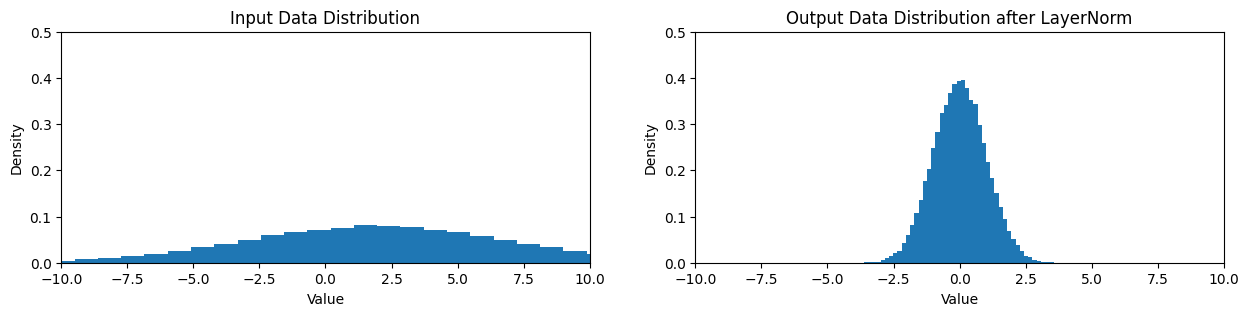

In [60]:
# Create input data
batch_size, d_model = 1000, 64
input_data = torch.randn(batch_size, d_model) * 5 + 2  # Mean = 2, Std = 5

# Initialize and apply LayerNorm
layer_norm = LayerNorm(d_model)
output_data = layer_norm(input_data)

def plot_distribution(ax, data, title):
    ax.hist(data.flatten().detach().numpy(), bins=50, density=True)
    ax.set_title(title)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 0.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
plot_distribution(ax1, input_data, "Input Data Distribution")
plot_distribution(ax2, output_data, "Output Data Distribution after LayerNorm")

Let's bundle everything together into a simple transformer layer. Self-attention refers to the fact that our input sequence `src` attends to itself via attention!

In [21]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttentionLayer, self).__init__()
        self.self_attn = SingleHeadAttention(embed_dim)
        self.norm1 = LayerNorm(embed_dim)

    def forward(self, src, mask=None):
        src = src + self.norm1(self.self_attn(src, mask=mask))
        return src

## Positional Encoding

Attention operates over all pairs of positions. This means it's invariant with regards to position - the attention calculation from token 5 to token 1 and token 5 to token 2 are the same by default. We don't want this - nearby tokens should be more relevant. 

`PositionalEncoding` class is a crucial component in transformer-based models. It adds positional information to input embeddings, allowing the model to understand the sequence order of inputs.

We want to insert some unique positional information. Our implementation of  `PositionalEncoding` class uses sine and cosine functions of different frequencies to generate these unique positional embeddings for each position in the input sequence. These embeddings are then added to the input embeddings to provide positional context.

The encoding for a position `pos` and dimension `i` is given by:

\begin{align}
PE_{(pos, 2i)} &= \sin(pos / 100^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &= \cos(pos / 100^{2i/d_{model}})
\end{align}

where $d_{model}$ is the dimensionality of the model.



In [39]:
def positional_encoding(position, d_model):
    pe = torch.zeros(position.size(0), d_model)
    position = torch.arange(0, position.size(0), dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(100.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Plot for positions 0-99 and dimensions 0, 1, 2, 3
positions = torch.arange(100).float()
d_model = 512

We can plot the sine and cosine functions for different dimensions.

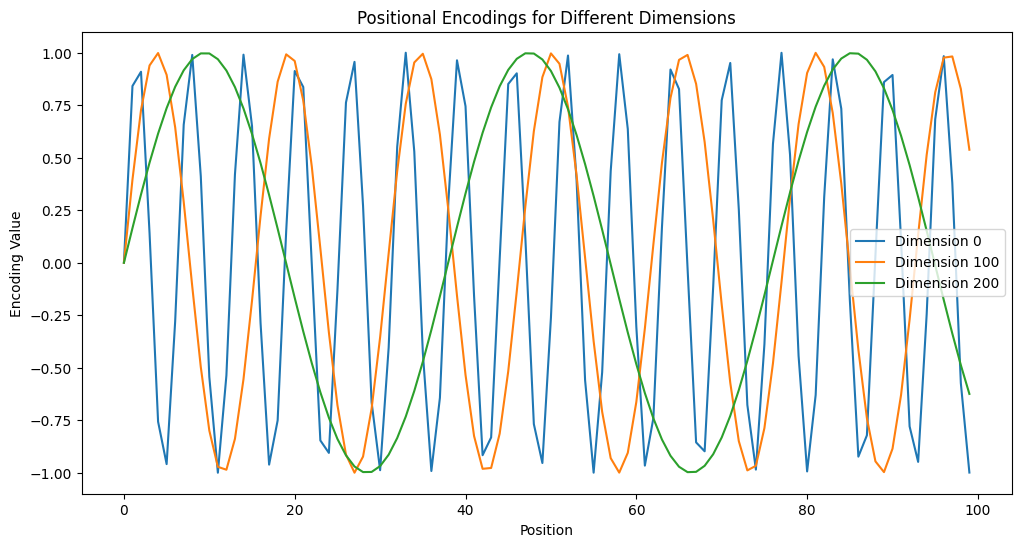

In [40]:
plt.figure(figsize=(12, 6))
pe = positional_encoding(positions, d_model)
for i in [0,100,200]:
    plt.plot(positions.numpy(), pe[:, i].numpy(), label=f'Dimension {i}')

plt.legend()
plt.title("Positional Encodings for Different Dimensions")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.show()

Lets see how different positions `[0, 10, 25, 50]` are represented across a model dimension of 512.

The x-axis represents the dimensions of the encoding vector, while the y-axis shows the encoding value, ranging from -1 to 1. Each line represents a different position's encoding.

As we move from left to right, the frequency of the waves decreases, resulting in the visible pattern change. Lower dimensions (left side) use higher frequency waves, allowing for fine-grained position differentiation. Higher dimensions (right side) use lower frequency waves, capturing broader positional information. This multi-scale representation enables the model to capture both local and global positional relationships in the input sequence.

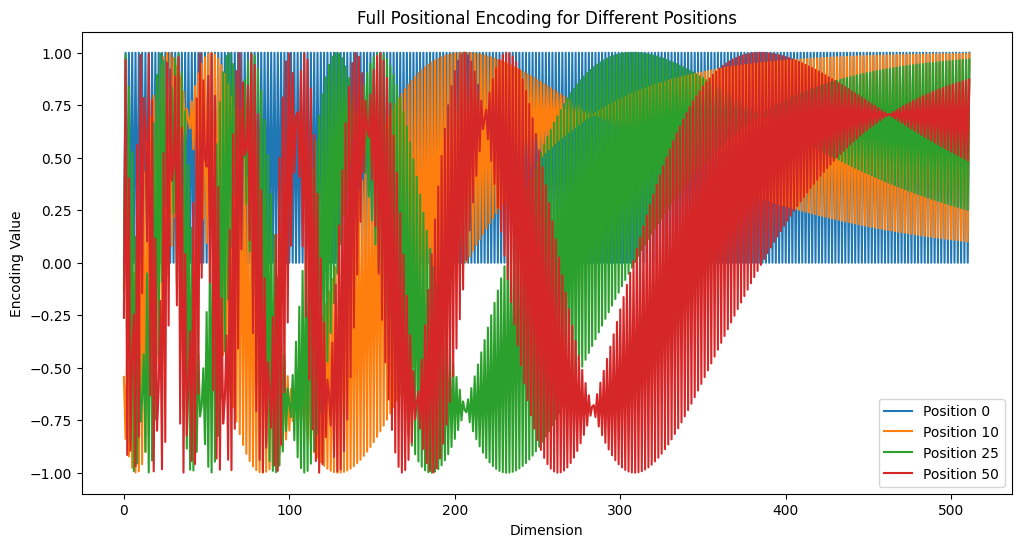

In [23]:
plt.figure(figsize=(12, 6))
for pos in [0, 10, 25, 50]:
    plt.plot(pe[pos].numpy(), label=f'Position {pos}')

plt.legend()
plt.title("Full Positional Encoding for Different Positions")
plt.xlabel("Dimension")
plt.ylabel("Encoding Value")
plt.show()

Now, integrate your positional encoding into the module PositionalEncoding. It should accept an input `x`.

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(100.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

## Putting It All Together: A Simple Transformer Implementation

The provided code demonstrates how the key components we've discussed - positional encoding, layer normalization, and self-attention layers - come together to form a basic transformer model. Let's break down the `TransformerModel` class:

1. **Initialization (`__init__`)**:
   - `self.embed`: An embedding layer that converts input tokens to dense vectors.
   - `self.pos_encoder`: Adds positional information to the embedded tokens.
   - `self.layers`: A list of `SelfAttentionLayer` modules, forming the core of the transformer.
   - `self.norm`: A final layer normalization applied after all attention layers.
   - `self.decoder`: A linear layer that projects the final representations to vocabulary-sized logits.

2. **Forward Pass (`forward`)**:
   - Creates an attention mask to ensure the model only attends to previous tokens (for causal/autoregressive modeling).
   - Embeds the input tokens and adds positional encodings.
   - Passes the embeddings through each self-attention layer sequentially.
   - Applies a final layer normalization.
   - Projects the output to vocabulary-sized logits using the decoder.

This implementation showcases how:
- Positional encodings are added to token embeddings at the start.
- Multiple self-attention layers are stacked to process the input deeply.
- Layer normalization is applied both within the attention layers (not shown here, but typically part of `SelfAttentionLayer`) and at the end of the entire stack.
- The model maintains the same dimensionality (`embed_dim`) throughout, using residual connections (likely within `SelfAttentionLayer`) to facilitate gradient flow.

This structure allows the transformer to effectively process sequential data while maintaining awareness of token positions and leveraging the power of self-attention mechanisms.

In [25]:
class CogModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers):
        super(CogModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.layers = nn.ModuleList([SelfAttentionLayer(embed_dim) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.decoder = nn.Linear(embed_dim, vocab_size)

    def forward(self, src):
        mask = torch.triu(torch.ones(
            src.size(1), src.size(1), dtype=torch.bool, device=src.device)).T
        src = self.embed(src)
        src = self.pos_encoder(src)
        for layer in self.layers:
            src = layer(src, mask)
        src = self.norm(src)
        output = self.decoder(src)
        return output


Rather than training the transformer yourself, we've trained it for you on a toy task.

In [26]:
from utils import load_cogmodel

model, tokenizer = load_cogmodel()

/share/u/caden/.conda/envs/work/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


You can call "echo" following a word to have the model repeat the word, or "upper" to repeat the word in all caps.

Let's play around with the model! Write a generate text method to play around with the model's outputs. Note that the model isn't perfect at performing the sequence tasks it was trained on - if you want, go check out the notebook today's exercises were based on to see if you can do better!

In [38]:
def generate_text(prompt, max_len=28):

    prompt_tensor = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(max_len):
        output = model(prompt_tensor)
        pred_token = output.argmax(dim=2)[:,-1]
        if pred_token == 0:
            break
        prompt_tensor = torch.cat((prompt_tensor, pred_token.unsqueeze(0)), dim=1)

    predicted_sentence = "".join(tokenizer.batch_decode(prompt_tensor[0]))
    return predicted_sentence

result = generate_text('minecraft echo mine up upper')
result

'minecraft echo mine up upper MIECRAFT. '